# FAERS AE Multilabel Outcomes ML pipeline - Dask Distributed + Joblib + Dask DataFrames

## Methodology

### Objective
**Use FAERS data on drug safety to identify possible risk factors associated with patient mortality and other serious adverse events associated with approved used of a drug or drug class** 

### Data
**_Outcome table_** 
1. Start with outcome_c table to define unit of analysis (primaryid)
2. Reshape outcome_c to one row per primaryid
3. Outcomes grouped into 3 categories: a. death, b. serious, c. other  
4. Multiclass model target format: each outcome grp coded into separate columns

**_Demo table_**
1. Drop fields not used in model input to reduce table size (preferably before import to notebook)
2. Check if demo table one row per primaryid (if NOT then need to reshape / clean - TBD)

**_Model input and targets_**
1. Merge clean demo table with reshaped multilabel outcome targets (rows: primaryid, cols: outcome grps)
2. Inspect merged file to check for anomalies (outliers, bad data, ...)

### Model
**_Multilabel Classifier_**
1. Since each primaryid has multiple outcomes coded in the outcome_c table, the ML model should predict the probability of each possible outcome.
2. In scikit-learn lib most/all classifiers can predict multilabel outcomes by coding target outputs into array

### Results
TBD

### Insights
TBD

In [1]:
# scale sklearn dask example setup - compare to multi thread below
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:39673 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.00 GB


In [6]:
#import libraries
import numpy as np
print('The numpy version is {}.'.format(np.__version__))
import pandas as pd
print('The pandas version is {}.'.format(pd.__version__))
from pandas import read_csv, DataFrame
# dask dataframe
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
print('The dask version is {}.'.format(dask.__version__))
#from random import random
import sklearn
#from sklearn.base import (BaseEstimator, TransformerMixin)
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import joblib
from joblib import dump, load
print('The joblib version is {}.'.format(joblib.__version__))

# preprocess + model selection + pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler  #, LabelBinarizer, MultiLabelBinarizer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.model_selection import train_test_split, GridSearchCV  #, cross_val_score, 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

# models supporting multilabel classification
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV

# libs for managing imbalanced classes
from sklearn.utils import resample

# metrics appropriate for multilabel classification
from sklearn.metrics import jaccard_score, hamming_loss, accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay 

# feature importance
from sklearn.inspection import permutation_importance, partial_dependence, plot_partial_dependence

# visualization
import matplotlib as mpl
print('The matplotlib version is {}.'.format(mpl.__version__))
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
print('The seaborn version is {}.'.format(sns.__version__))
sns.set()

# dtree viz libs
import pydotplus
from io import StringIO
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import Image

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# utilities for timing decorator
import time
from functools import wraps

def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f'@timefn: {fn.__name__} took {t2 - t1} seconds')
        return result
    return measure_time



The numpy version is 1.19.5.
The pandas version is 1.2.0.
The dask version is 2020.12.0.
The scikit-learn version is 0.24.0.
The joblib version is 0.13.0.
The matplotlib version is 3.0.2.
The seaborn version is 0.9.0.


In [7]:
%%time
# read data into dask dataframe

# provide path to datafile
file_in = '../input/demo-outc_cod-multilabel-wt_lbs-age_yrs.csv'
# provide list of fields to import (alt-read in all cols and use df.drop(['cols2drop'],axis = 1)
cols_in = ['primaryid', 'i_f_code', 'rept_cod', 'sex', 'occp_cod', 'outc_cod__CA', 
           'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT', 'outc_cod__OT', 
           'outc_cod__RI', 'n_outc', 'wt_lbs', 'age_yrs']
#@timefn
def data_in(infile, incols):
    """Used to time reading data from source"""   
    ddf = dd.read_csv(infile, usecols=incols)
    print(ddf.columns, '\n')
    print(ddf.head(),'\n')
    print(f'Total number of rows: {len(ddf):,}\n')
    ddf2 = ddf.primaryid.nunique().compute()
    print(f'Unique number of primaryids: {ddf2}')
    return ddf
    
    
if __name__=='__main__':
    ddf = data_in(file_in, cols_in)

Index(['primaryid', 'i_f_code', 'rept_cod', 'sex', 'occp_cod', 'outc_cod__CA',
       'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT',
       'outc_cod__OT', 'outc_cod__RI', 'n_outc', 'wt_lbs', 'age_yrs'],
      dtype='object') 

   primaryid i_f_code rept_cod sex occp_cod  outc_cod__CA  outc_cod__DE  \
0  100046942        F      EXP   F       LW             0             0   
1  100048206        F      EXP   F       MD             0             0   
2  100048622        F      EXP   F       LW             0             0   
3  100051352        F      EXP   F       LW             0             0   
4  100051382        F      EXP   F       LW             0             0   

   outc_cod__DS  outc_cod__HO  outc_cod__LT  outc_cod__OT  outc_cod__RI  \
0             0             0             0             1             0   
1             0             1             0             1             0   
2             0             0             0             1             0   
3   

In [8]:
with ProgressBar():
    display(ddf.head())

,primaryid,i_f_code,rept_cod,sex,occp_cod,outc_cod__CA,outc_cod__DE,outc_cod__DS,outc_cod__HO,outc_cod__LT,outc_cod__OT,outc_cod__RI,n_outc,wt_lbs,age_yrs
0,100046942,F,EXP,F,LW,0,0,0,0,0,1,0,1,178.574463,NaN
1,100048206,F,EXP,F,MD,0,0,0,1,0,1,0,2,NaN,68.0
2,100048622,F,EXP,F,LW,0,0,0,0,0,1,0,1,NaN,57.0
3,100051352,F,EXP,F,LW,0,0,0,0,0,1,0,1,NaN,51.0
4,100051382,F,EXP,F,LW,0,0,0,0,0,1,0,1,182.983709,50.0


## ML Pipeline - Preprocessing step

In [9]:
# dask: data prep + preprocessor + pipeline funcs
def df_prep(ddf):
    """df_prep func used in pipeline to support select features and prep multilabel targets for clf
    assumes dask DataFrame is named 'ddf'
    """ 
    # compute ddf
    #ddf2 = ddf.compute()
    # drop fields from df when defining model targets and features
    y_drop = ['primaryid', 'i_f_code', 'rept_cod', 'sex', 'occp_cod', 'n_outc', 'wt_lbs', 'age_yrs']         
    X_drop = ['primaryid', 'outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 
              'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI']
    # convert target to ndarray for sklearn
    y = ddf.drop(y_drop, axis=1).compute()
    y_arr = y.to_numpy()  # look into dask array
    X = ddf.drop(X_drop, axis=1).compute()
    print('Step 0: Create ndarray for multilabel targets + select model features','\n')
    print('y_arr\n', y_arr.shape, '\n', y_arr.dtype, '\n', y_arr[:2], y.columns, '\n')
    print('X\n', X.shape, '\n', X.dtypes, '\n', X[:2],'\n', X.columns, '\n')
    return X, y_arr

def preprocessor():
    "make data preprocessor for pipeline"

    # 2. group features by type for categorical vs numeric transformers
    num_features = ['n_outc', 'wt_lbs', 'age_yrs']  
    cat_features = ['i_f_code', 'rept_cod', 'sex', 'occp_cod']  
    feature_labels = num_features + cat_features
    print('Step 2: Group features by type for pipeline\n')
    print('num_features\n', num_features)
    print('cat_features\n', cat_features)
    print('feature_labels\n', feature_labels,'\n')
    
    # 3. create transformers for model input features by type
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    cat_transformer = Pipeline(steps=[
        ('1_hot', OneHotEncoder(handle_unknown='ignore'))])
    print('Step 3: Column transformers by type for pipeline\n')
    print('num_transformer\n', num_transformer)
    print('cat_transformer\n', cat_transformer,'\n')

    # 4. combine transformers into preprocessing step
    preprocessor = ColumnTransformer(transformers=[
        #('dfprep', dfprep_transformer, all_features),
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)], remainder='passthrough') 
    print('Step 4: Preprocessor for pipeline\n')
    print('preprocessor\n', preprocessor,'\n')
    return preprocessor

def model_fit(X_, y_):
    # fit clfs using dask with joblib backend
    for classifier in classifiers:
        ml_pipe = Pipeline(steps=[('preprocessor', preprocessor()),
                                  ('classifier', MultiOutputClassifier(classifier))
                                 ]
                          )
        # use context manager to run dask during training
        with joblib.parallel_backend('dask'):
            ml_clf = ml_pipe.fit(X_, y_)
            
            
        # save/load fited clf obj with joblib
        dump(ml_clf, 'ml_clf_obj.joblib')   
        ml_clf_obj = load('ml_clf_obj.joblib')
        return ml_clf_obj
            
        
# 6. ml clf model pipe
def ml_clf_pipe(clf_lst):
    """Pipeline to evaluate multilabel classifiers prior to hyperparameter tuning."""
    # 0. data prep
    X, y_arr = df_prep(ddf)
    # 1. train, test set split (can extend later to multiple train-test splits in pipeline)
    X_train, X_test, y_train, y_test = train_test_split(X, y_arr, test_size = 0.3)
    print('Step 1: Train-test set split\n')
    print('X_train\n', X_train.shape, '\n', X_train[:2])
    print('y_train\n', y_train.shape, '\n', y_train[:2])
    print('X_test\n', X_test.shape, '\n', X_test[:2])
    print('y_test\n', y_test.shape, '\n', y_test[:2],'\n')
               
    # train, dump & load model    
    ml_clf_obj = model_fit(X_train, y_train)

    y_pred = ml_clf_obj.predict(X_test)
    print('y_pred\n', y_pred.shape,'\n',y_pred[3:],'\n')

    print('Multilabel Classifier: Performance Metrics:\n')
    # accuracy, hamming loss and jaccard score for mlabel
    print('accuracy: ', accuracy_score(y_test, y_pred))
    print('hamming loss: ', hamming_loss(y_test, y_pred))
    print('jaccard score: ', jaccard_score(y_test, y_pred, average='micro'))
    print('roc auc score: ', roc_auc_score(y_test, y_pred))
    print('average precision score: ', average_precision_score(y_test, y_pred),'\n')

    # generate ml cm
    multilabel_cm = multilabel_confusion_matrix(y_test, y_pred)
    # calc tp, tn, fp, fn rates
    tp = multilabel_cm[:, 0, 0]
    tn = multilabel_cm[:, 1, 1]
    fp = multilabel_cm[:, 0, 1]
    fn = multilabel_cm[:, 1, 0]

    outc_labels = ['outc_cod__CA','outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT', 
                   'outc_cod__OT',  'outc_cod__RI']
    print('Recall, Specificity, Fall Out and Miss Rate for Multilabel Adverse Event Outcomes:\n', outc_labels)
    # recall
    print('recall (true pos rate):\n', tp / (tp + fn))
    # specificity
    print('specificity (true neg rate):\n', tn / (tn + fp))
    # fall out
    print('fall out (false pos rate):\n', fp / (fp + tn))
    # miss rate
    print('miss rate (false neg rate):\n', fn / (fn + tp), '\n')

    # plot multilabel confusion matrix
    def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
        df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names) 
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap="YlGnBu")  #cmap='RdBu_r', 
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', 
                                     fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', 
                                     fontsize=fontsize)
        axes.set_xlabel('True label')
        axes.set_ylabel('Predicted label')
        axes.set_title("Confusion matrix for class - " + class_label)

    # plot grid of cm's - one per output - raw
    fig, ax = plt.subplots(3, 3, figsize=(12, 7))

    for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_cm, outc_labels):  # labels):
        print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

    fig.tight_layout()
    plt.show()

    # corr matrix heatmap 
    y_df = pd.DataFrame(y_pred, columns=outc_labels)
    ncol = y_df.shape[1]
    fig, ax = plt.subplots(figsize=(ncol,ncol))
    ax = sns.heatmap(y_df.corr(), fmt='.2f', annot=True, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1)
    imgname = str(classifiers[0]) + '-hmap_corr.png'
    fig.savefig(imgname, dpi=300, bbox_inches='tight')
    print('Correlation Matrix Heatmap of Predicted Multilabel Adverse Events\n')
    plt.show()


## Decision Tree Classifier

Step 0: Create ndarray for multilabel targets + select model features 

y_arr
 (260715, 7) 
 int64 
 [[0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0]] Index(['outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO',
       'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI'],
      dtype='object') 

X
 (260715, 7) 
 i_f_code     object
rept_cod     object
sex          object
occp_cod     object
n_outc        int64
wt_lbs      float64
age_yrs     float64
dtype: object 
   i_f_code rept_cod sex occp_cod  n_outc      wt_lbs  age_yrs
0        F      EXP   F       LW       1  178.574463      NaN
1        F      EXP   F       MD       2         NaN     68.0 
 Index(['i_f_code', 'rept_cod', 'sex', 'occp_cod', 'n_outc', 'wt_lbs',
       'age_yrs'],
      dtype='object') 

Step 1: Train-test set split

X_train
 (182500, 7) 
        i_f_code rept_cod sex occp_cod  n_outc  wt_lbs  age_yrs
122096        I      EXP   M       CN       1     NaN     66.0
130518        F      EXP   M       MD       2     NaN     71

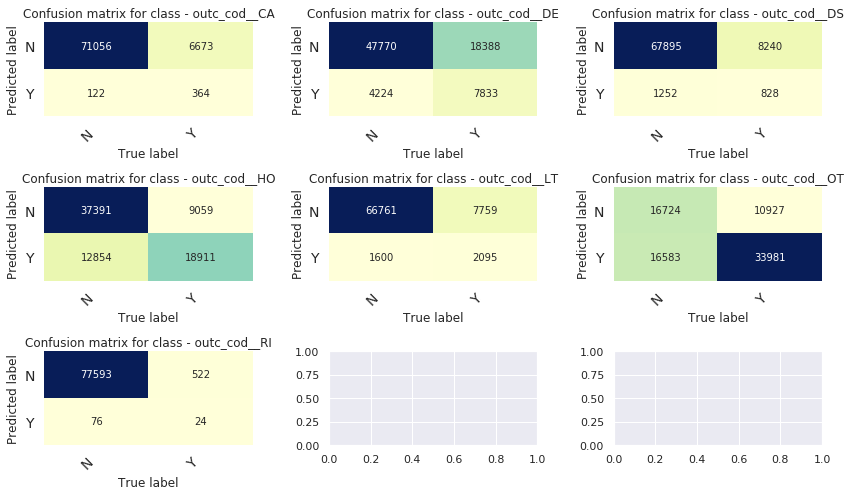

Correlation Matrix Heatmap of Predicted Multilabel Adverse Events



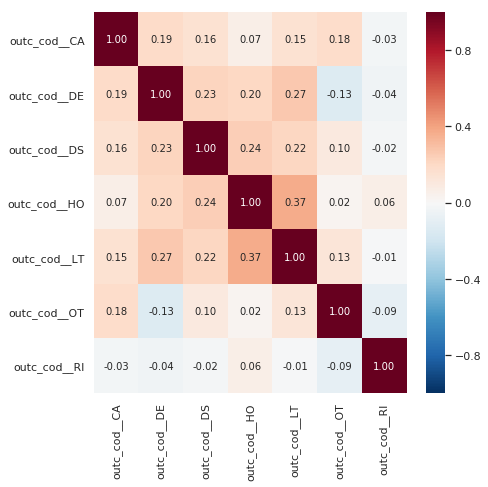

In [19]:
# multilabel clfs
classifiers = [   
    #RidgeClassifierCV(class_weight='balanced'),
    DecisionTreeClassifier(class_weight='balanced'),
    #ExtraTreesClassifier(class_weight='balanced'),
    #RandomForestClassifier(class_weight='balanced'),
    #MLPClassifier(solver='sdg', learning_rate='adaptive', early_stopping=True),
    #KNeighborsClassifier(weights='distance'),
    #RadiusNeighborsClassifier(weights='distance')
]
  
# fit and eval model
if __name__ == '__main__':
    ml_clf_pipe(classifiers)
    
    

In [11]:
# use model object to create predictions on new data

# load fit clf
ml_clf_obj = load('ml_clf_obj.joblib')
dir(ml_clf_obj)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_fit_params',
 '_check_n_features',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_inverse_transform',
 '_iter',
 '_log_message',
 '_more_tags',
 '_pairwise',
 '_replace_estimator',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_params',
 '_sk_visual_block_',
 '_transform',
 '_validate_data',
 '_validate_names',
 '_validate_steps',
 'classes_',
 'decision_function',
 'fit',
 'fit_predict',
 'fit_tr

In [17]:
# predict multilabel outcomes
# prep new data
X, y_arr = df_prep(ddf)
# predict ml outcomes
y_arr_pred = ml_clf_obj.predict(X)
print('Predicted AEs: DecisionTree Classifier\n', y_arr_pred.shape, '\n', y_arr_pred[5:])

Predicted AEs: DecisionTree Classifier
 (260715, 7) 
 [[0 0 0 ... 0 1 0]
 [0 1 0 ... 1 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


## Random Forest Classifier

Step 0: Create ndarray for multilabel targets + select model features 

y_arr
 (260715, 7) 
 int64 
 [[0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0]] Index(['outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO',
       'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI'],
      dtype='object') 

X
 (260715, 7) 
 i_f_code     object
rept_cod     object
sex          object
occp_cod     object
n_outc        int64
wt_lbs      float64
age_yrs     float64
dtype: object 
   i_f_code rept_cod sex occp_cod  n_outc      wt_lbs  age_yrs
0        F      EXP   F       LW       1  178.574463      NaN
1        F      EXP   F       MD       2         NaN     68.0 
 Index(['i_f_code', 'rept_cod', 'sex', 'occp_cod', 'n_outc', 'wt_lbs',
       'age_yrs'],
      dtype='object') 

Step 1: Train-test set split

X_train
 (182500, 7) 
        i_f_code rept_cod  sex occp_cod  n_outc  wt_lbs  age_yrs
215322        F      EXP    F       HP       1     NaN     20.0
147333        F      EXP  NaN       CN       1     NaN    

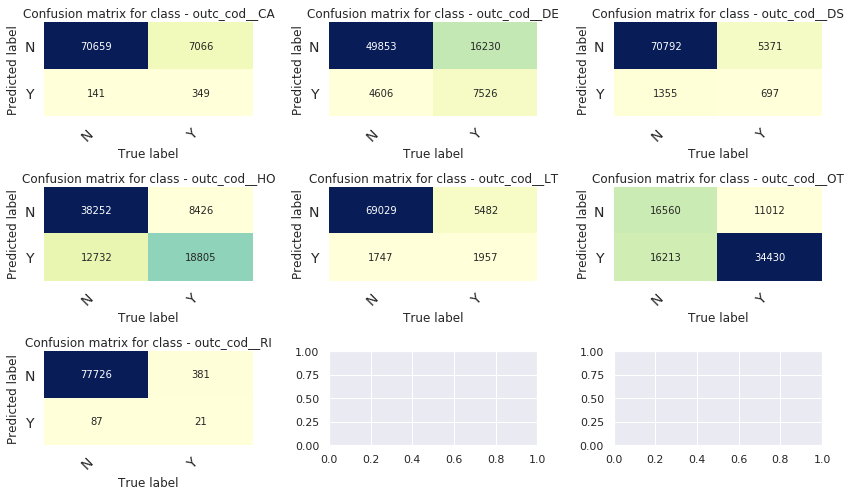

Correlation Matrix Heatmap of Predicted Multilabel Adverse Events



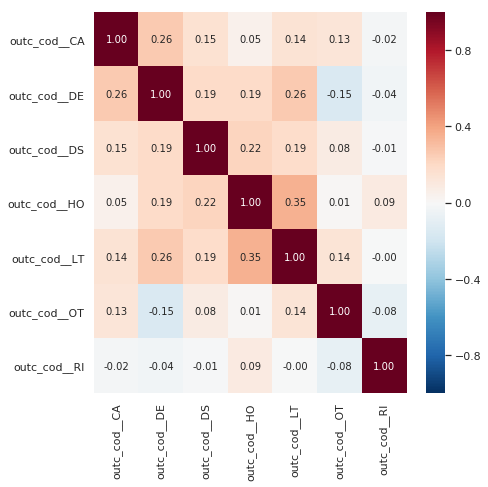

In [18]:
# multilabel clfs
classifiers = [   
    #RidgeClassifierCV(class_weight='balanced'),
    #DecisionTreeClassifier(class_weight='balanced'),
    #ExtraTreesClassifier(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
    #MLPClassifier(solver='sdg', learning_rate='adaptive', early_stopping=True),
    #KNeighborsClassifier(weights='distance'),
    #RadiusNeighborsClassifier(weights='distance')
]
  
# fit and eval model
if __name__ == '__main__':
    ml_clf_pipe(classifiers)

In [19]:
# use model object to create predictions on new data

# load fit clf
ml_clf_obj = load('ml_clf_obj.joblib')
dir(ml_clf_obj)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_fit_params',
 '_check_n_features',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_inverse_transform',
 '_iter',
 '_log_message',
 '_more_tags',
 '_pairwise',
 '_replace_estimator',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_params',
 '_sk_visual_block_',
 '_transform',
 '_validate_data',
 '_validate_names',
 '_validate_steps',
 'classes_',
 'decision_function',
 'fit',
 'fit_predict',
 'fit_tr

In [20]:
# predict multilabel outcomes
# prep new data
X, y_arr = df_prep(ddf)
# predict ml outcomes
y_arr_pred = ml_clf_obj.predict(X)
print('Predicted AEs: RandomForest Classifier\n', y_arr_pred.shape, '\n', y_arr_pred[5:])

Step 0: Create ndarray for multilabel targets + select model features 

y_arr
 (260715, 7) 
 int64 
 [[0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0]] Index(['outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO',
       'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI'],
      dtype='object') 

X
 (260715, 7) 
 i_f_code     object
rept_cod     object
sex          object
occp_cod     object
n_outc        int64
wt_lbs      float64
age_yrs     float64
dtype: object 
   i_f_code rept_cod sex occp_cod  n_outc      wt_lbs  age_yrs
0        F      EXP   F       LW       1  178.574463      NaN
1        F      EXP   F       MD       2         NaN     68.0 
 Index(['i_f_code', 'rept_cod', 'sex', 'occp_cod', 'n_outc', 'wt_lbs',
       'age_yrs'],
      dtype='object') 

Predicted AEs: RandomForest Classifier
 (260715, 7) 
 [[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


## RidgeClassifierCV

Step 0: Create ndarray for multilabel targets + select model features 

y_arr
 (260715, 7) 
 int64 
 [[0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0]] Index(['outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO',
       'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI'],
      dtype='object') 

X
 (260715, 7) 
 i_f_code     object
rept_cod     object
sex          object
occp_cod     object
n_outc        int64
wt_lbs      float64
age_yrs     float64
dtype: object 
   i_f_code rept_cod sex occp_cod  n_outc      wt_lbs  age_yrs
0        F      EXP   F       LW       1  178.574463      NaN
1        F      EXP   F       MD       2         NaN     68.0 
 Index(['i_f_code', 'rept_cod', 'sex', 'occp_cod', 'n_outc', 'wt_lbs',
       'age_yrs'],
      dtype='object') 

Step 1: Train-test set split

X_train
 (182500, 7) 
        i_f_code rept_cod sex occp_cod  n_outc      wt_lbs  age_yrs
108556        F      EXP   M       HP       2  176.369840     75.0
187688        I      EXP   M       MD       1  190.5

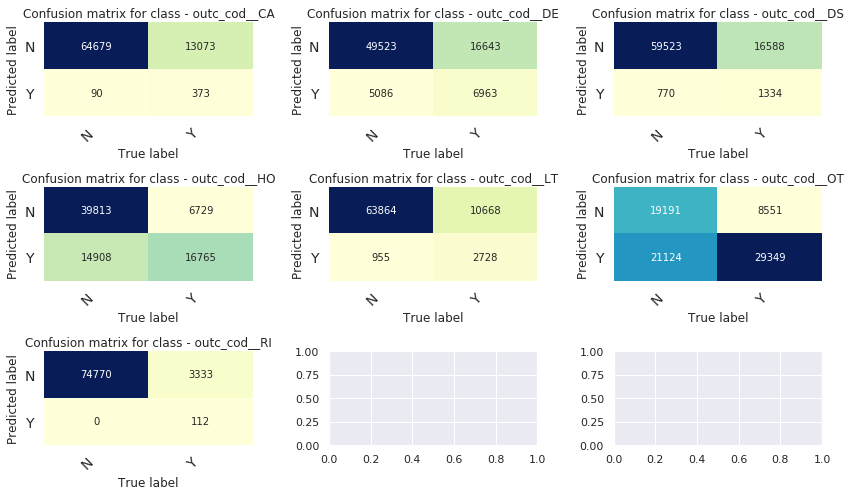

Correlation Matrix Heatmap of Predicted Multilabel Adverse Events



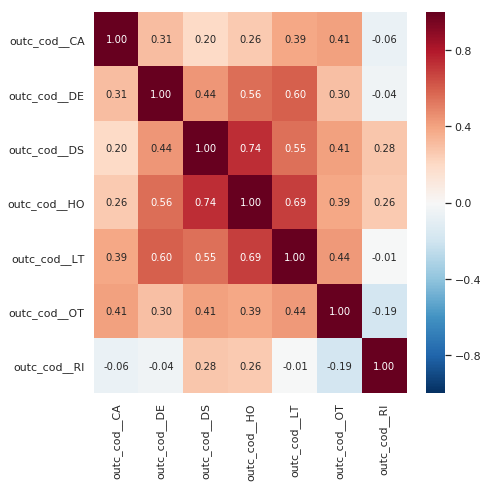

In [21]:
# multilabel clfs
classifiers = [   
    RidgeClassifierCV(class_weight='balanced'),
    #DecisionTreeClassifier(class_weight='balanced'),
    #ExtraTreesClassifier(class_weight='balanced'),
    #RandomForestClassifier(class_weight='balanced'),
    #MLPClassifier(solver='sdg', learning_rate='adaptive', early_stopping=True),
    #KNeighborsClassifier(weights='distance'),
    #RadiusNeighborsClassifier(weights='distance')
]
  
# fit and eval model
if __name__ == '__main__':
    ml_clf_pipe(classifiers)

In [22]:
# use model object to create predictions on new data

# load fit clf
ml_clf_obj = load('ml_clf_obj.joblib')
dir(ml_clf_obj)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_fit_params',
 '_check_n_features',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_inverse_transform',
 '_iter',
 '_log_message',
 '_more_tags',
 '_pairwise',
 '_replace_estimator',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_params',
 '_sk_visual_block_',
 '_transform',
 '_validate_data',
 '_validate_names',
 '_validate_steps',
 'classes_',
 'decision_function',
 'fit',
 'fit_predict',
 'fit_tr

In [23]:
# predict multilabel outcomes
# prep new data
X, y_arr = df_prep(ddf)
# predict ml outcomes
y_arr_pred = ml_clf_obj.predict(X)
print('Predicted AEs: RidgeClassifierCV\n', y_arr_pred.shape, '\n', y_arr_pred[5:])

Step 0: Create ndarray for multilabel targets + select model features 

y_arr
 (260715, 7) 
 int64 
 [[0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0]] Index(['outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO',
       'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI'],
      dtype='object') 

X
 (260715, 7) 
 i_f_code     object
rept_cod     object
sex          object
occp_cod     object
n_outc        int64
wt_lbs      float64
age_yrs     float64
dtype: object 
   i_f_code rept_cod sex occp_cod  n_outc      wt_lbs  age_yrs
0        F      EXP   F       LW       1  178.574463      NaN
1        F      EXP   F       MD       2         NaN     68.0 
 Index(['i_f_code', 'rept_cod', 'sex', 'occp_cod', 'n_outc', 'wt_lbs',
       'age_yrs'],
      dtype='object') 

Predicted AEs: RidgeClassifierCV
 (260715, 7) 
 [[1 0 1 ... 0 1 0]
 [1 1 1 ... 1 1 0]
 [0 0 1 ... 0 1 0]
 ...
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 0 1 0]]


# STOPPED HERE - 3.5.2021
TODOs: CLEAN UP NB, GITHUB, SLACK